# Importing Dataset from gdrive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
ZIPPED_PATH="/content/drive/MyDrive/car/car.zip"

Extraction complete.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SVM Model Accuracy: 0.6813
SVM Model Precision: 0.6857
SVM Model Recall Score: 0.6813
SVM Model F1 Score: 0.6818


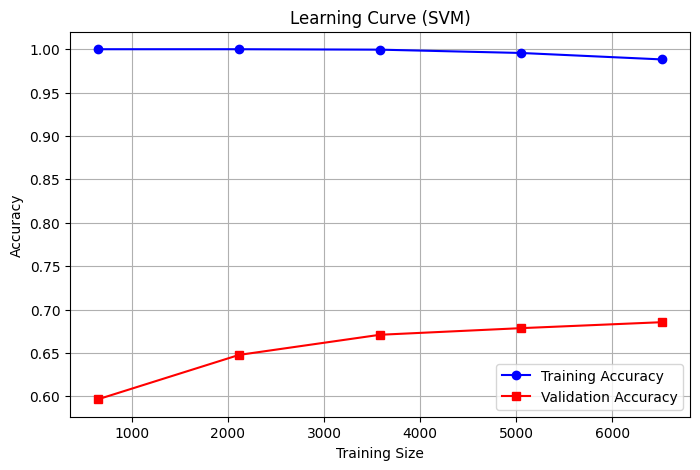

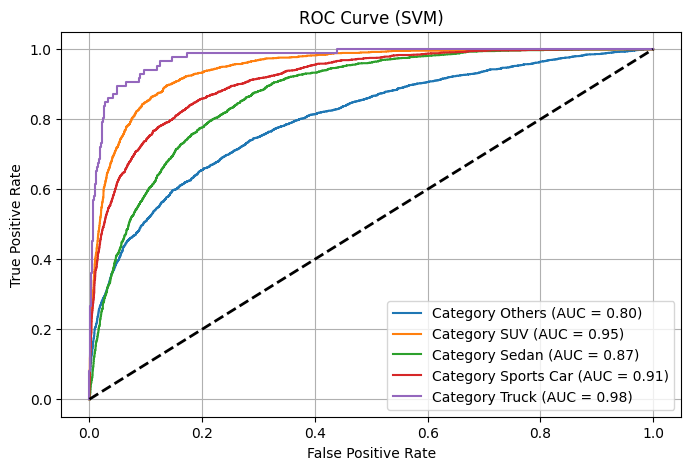

In [4]:
# Import necessary libraries
import torch
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image
import zipfile
import numpy as np
import pandas as pd
import os
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
)
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract dataset
extract_folder = "/content/cars"
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

with zipfile.ZipFile(ZIPPED_PATH, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
print("Extraction complete.")

# Load pre-trained ResNet-50 model (without final FC layer)
resnet = models.resnet50(pretrained=True)
resnet.fc = torch.nn.Identity()  # Remove final layer to get feature vector
resnet.to(device)
resnet.eval()

# Define Image Transform
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to extract features
def extract_features(img_path):
    try:
        image = Image.open(img_path).convert("RGB")
    except Exception as e:
        print("Error opening image:", e)
        return None
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feature_vector = resnet(image).cpu().numpy().flatten()
    return feature_vector

# Function to classify(group) car model names into higher categories
def classify_category(car_class):
    car_class_lower = car_class.lower()  # Convert to lowercase for easier matching

    if any(keyword in car_class_lower for keyword in ["truck", "pickup"]):
        return "Truck"
    elif any(keyword in car_class_lower for keyword in ["suv"]):
        return "SUV"
    elif any(keyword in car_class_lower for keyword in ["sedan"]):
        return "Sedan"
    elif any(keyword in car_class_lower for keyword in ["coupe", "convertible", "911", "corvette"]):
        return "Sports Car"
    elif any(keyword in car_class_lower for keyword in ["tesla"]):
        return "Electric"
    else:
        return "Others"  # Default category for unclassified cars

# Load annotations
trainDF = pd.read_excel('/content/drive/MyDrive/car/cars_with_class_names.xlsx', sheet_name='train')
testDF = pd.read_excel('/content/drive/MyDrive/car/cars_with_class_names.xlsx', sheet_name='test')

# Convert DataFrame to NumPy Array
trainArray = trainDF.to_numpy()
testArray = testDF.to_numpy()

# Paths to images
train_folder = os.path.join(extract_folder, "cars_train", "cars_train")
test_folder = os.path.join(extract_folder, "cars_test", "cars_test")

# Extract train features and labels
X_train, y_train = [], []
for entry in trainArray:
    img_path = os.path.join(train_folder, entry[7])
    if os.path.exists(img_path):
        feature_vector = extract_features(img_path)
        if feature_vector is not None:
            X_train.append(feature_vector)
            y_train.append(classify_category(entry[6]))

# Extract test features and labels
X_test, y_test = [], []
for entry in testArray:
    filename = str(entry[6]).strip("'\"")
    img_path = os.path.join(test_folder, filename)
    if os.path.exists(img_path):
        feature_vector = extract_features(img_path)
        if feature_vector is not None:
            X_test.append(feature_vector)
            y_test.append(classify_category(entry[5]))

# Convert to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Encode labels into numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train an SVM Classifier
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train_encoded)

# Make Predictions
y_pred = svm_model.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

print(f"SVM Model Accuracy: {accuracy:.4f}")
print(f"SVM Model Precision: {precision:.4f}")
print(f"SVM Model Recall Score: {recall:.4f}")
print(f"SVM Model F1 Score: {f1:.4f}")

# Function to plot learning curve
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 5)
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, label="Training Accuracy", marker="o", color="blue")
    plt.plot(train_sizes, test_mean, label="Validation Accuracy", marker="s", color="red")
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve (SVM)")
    plt.legend()
    plt.grid()
    plt.show()

# Plot Learning Curve
plot_learning_curve(svm_model, X_train, y_train_encoded)

# ROC Curve for Multi-Class Classification
y_test_bin = label_binarize(y_test_encoded, classes=np.unique(y_train_encoded))
svm_ovr = OneVsRestClassifier(SVC(kernel="linear", probability=True))
svm_ovr.fit(X_train, y_train_encoded)
y_score = svm_ovr.decision_function(X_test)

# Compute ROC curve and AUC for each class
n_classes = y_test_bin.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot Macro-Averaged ROC Curve
plt.figure(figsize=(8, 5))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Category {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SVM)")
plt.legend()
plt.grid()
plt.show()
